In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKAN, tlmdKAN, importance_analyse_lmdKAN, importance_analyse_tlmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
-----
## $f_1(x_1, x_2)$

##### $f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


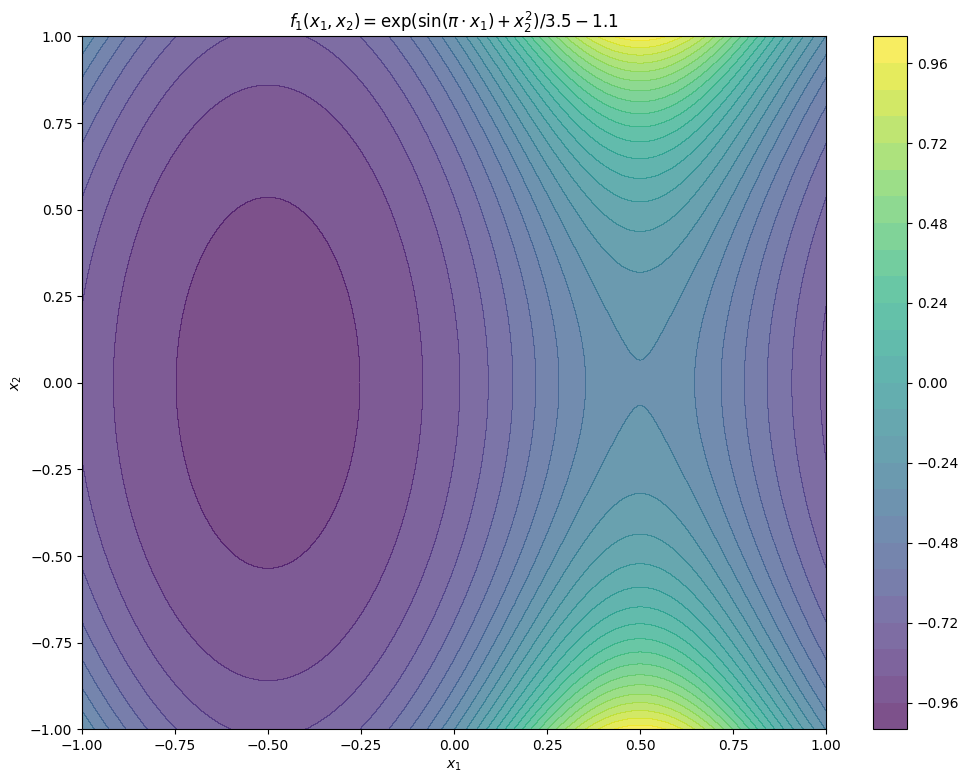

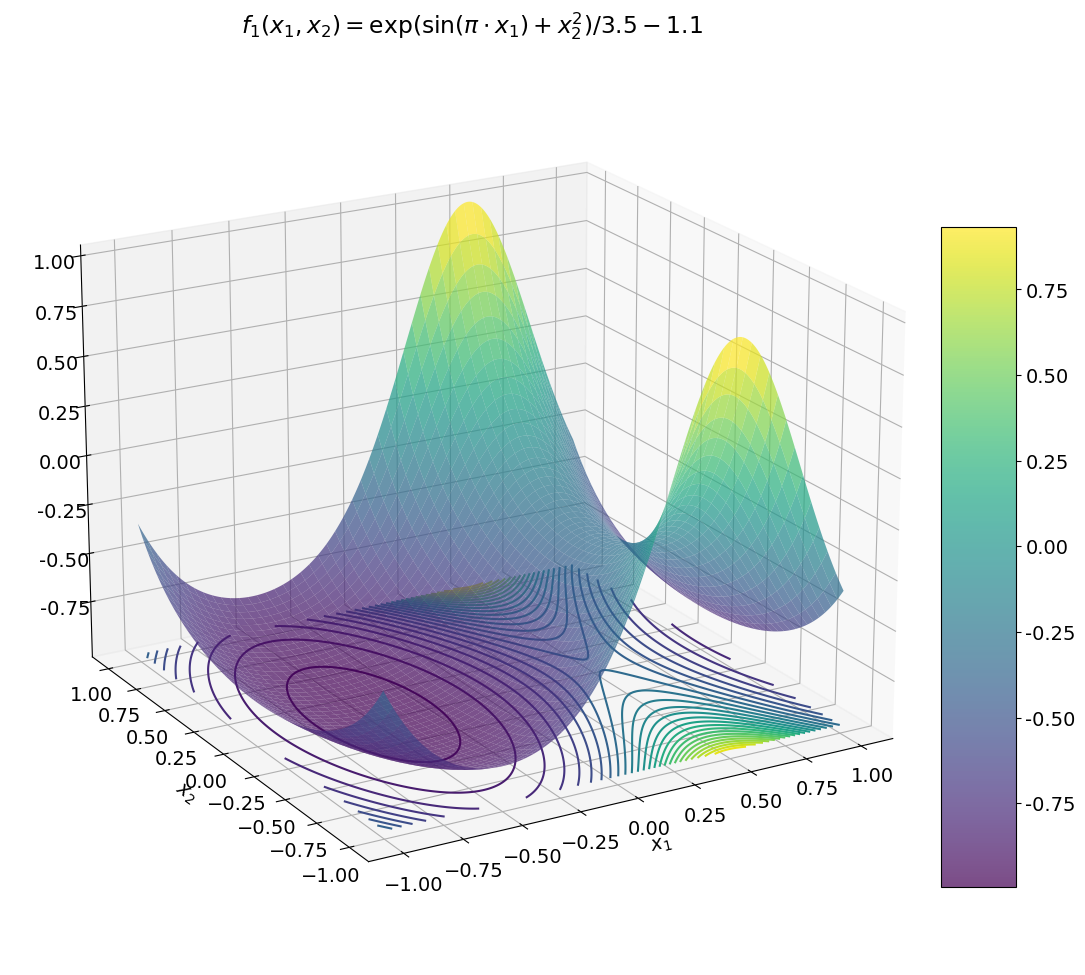

In [2]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) / 3.5 - 1.1
dataset1 = create_dataset(f1, n_var=2, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 216


| train_loss: 9.24e-03 | test_loss: 1.05e-02 | reg: 1.05e+02 | : 100%|█| 100/100 [00:04<00:00, 21.14


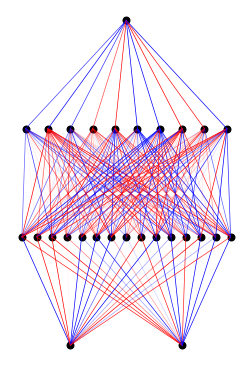

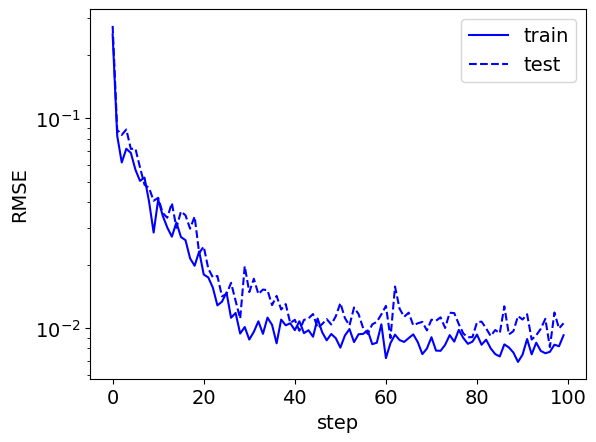

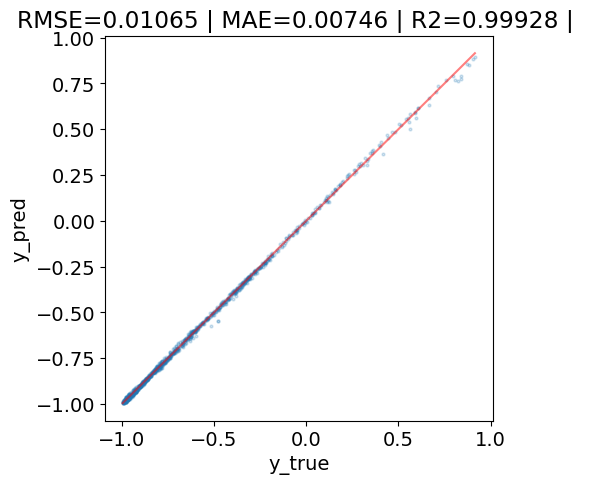

In [3]:
# initialize MLP
model = MLP(width=[2,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

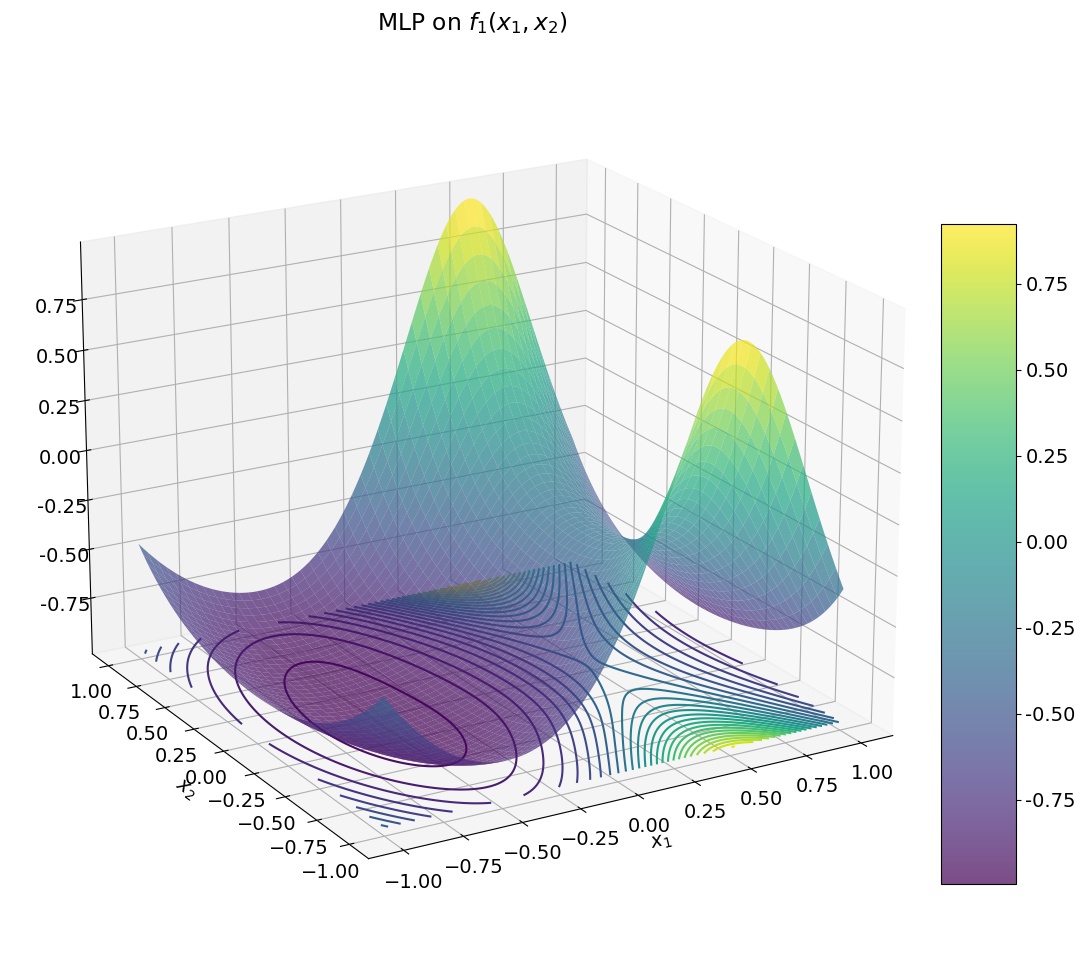

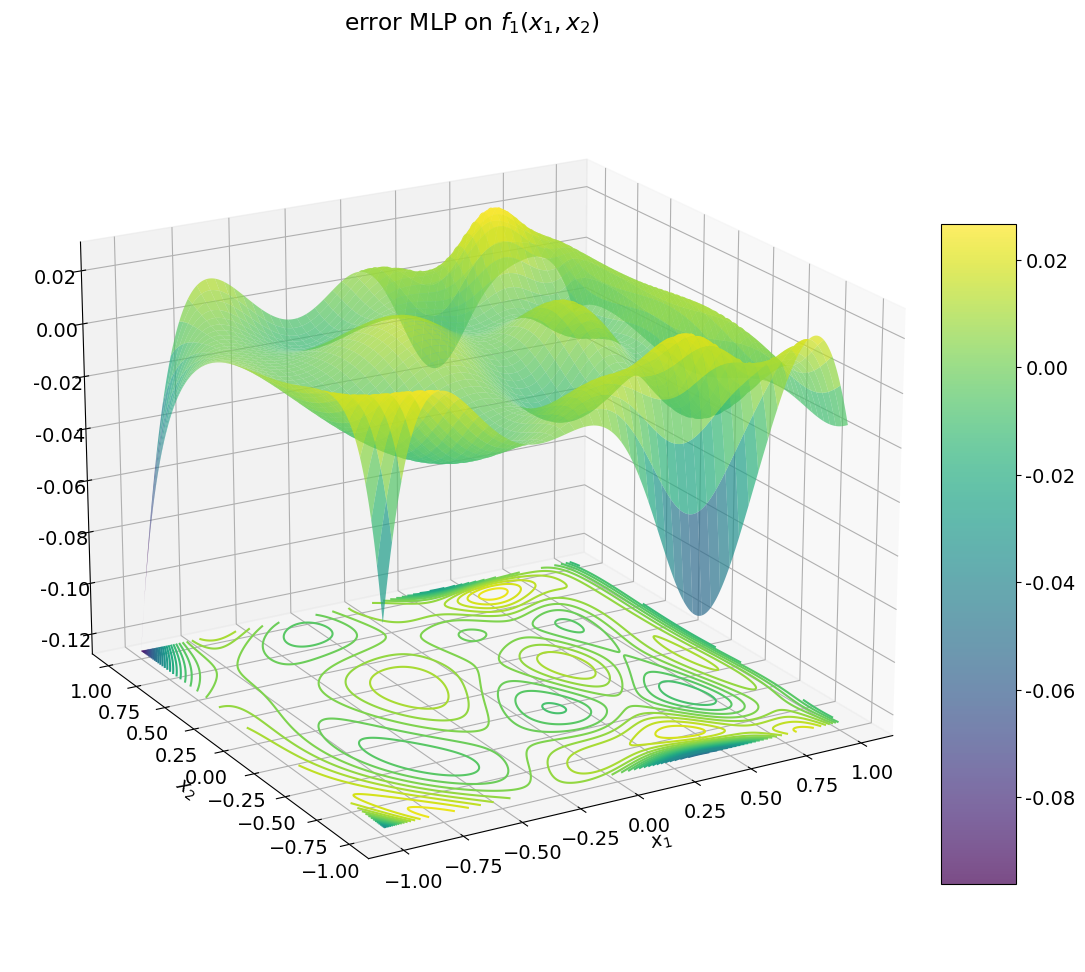

In [4]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='MLP on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error MLP on $f_1(x_1, x_2)$')

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 180


| train_loss: 3.71e-03 | test_loss: 2.58e-03 | reg: 7.21e+00 | : 100%|█| 100/100 [00:29<00:00,  3.38


saving model version 0.1


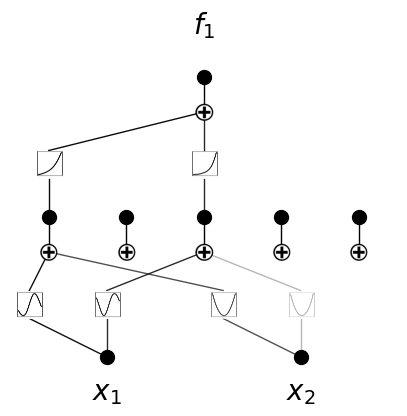

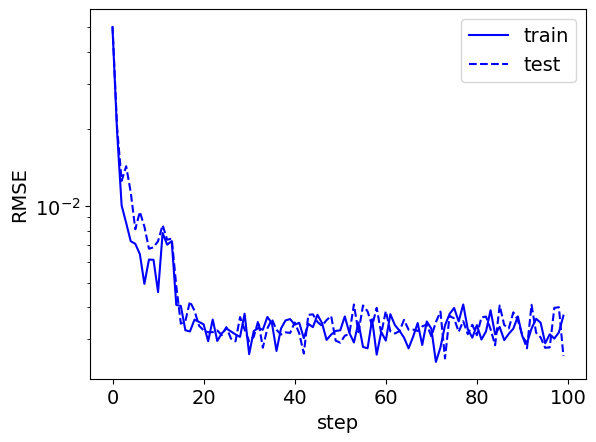

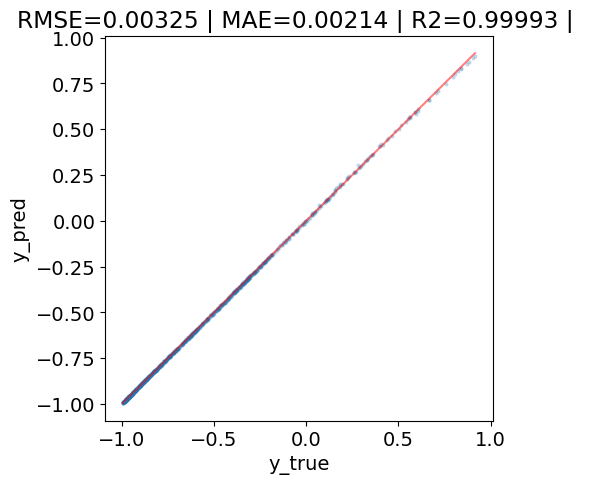

In [5]:
# initialize KAN with G=3
model = KAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$'], out_vars = ['$f_1$'])

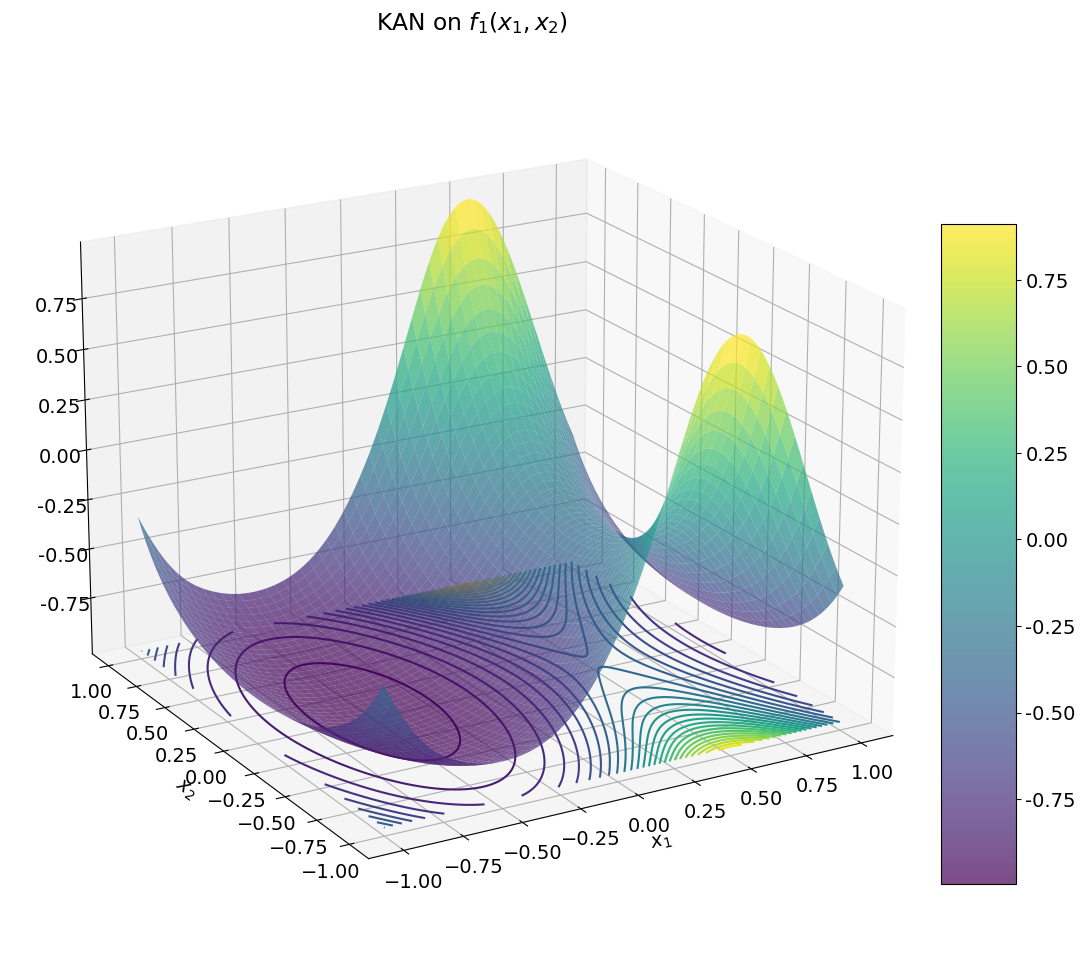

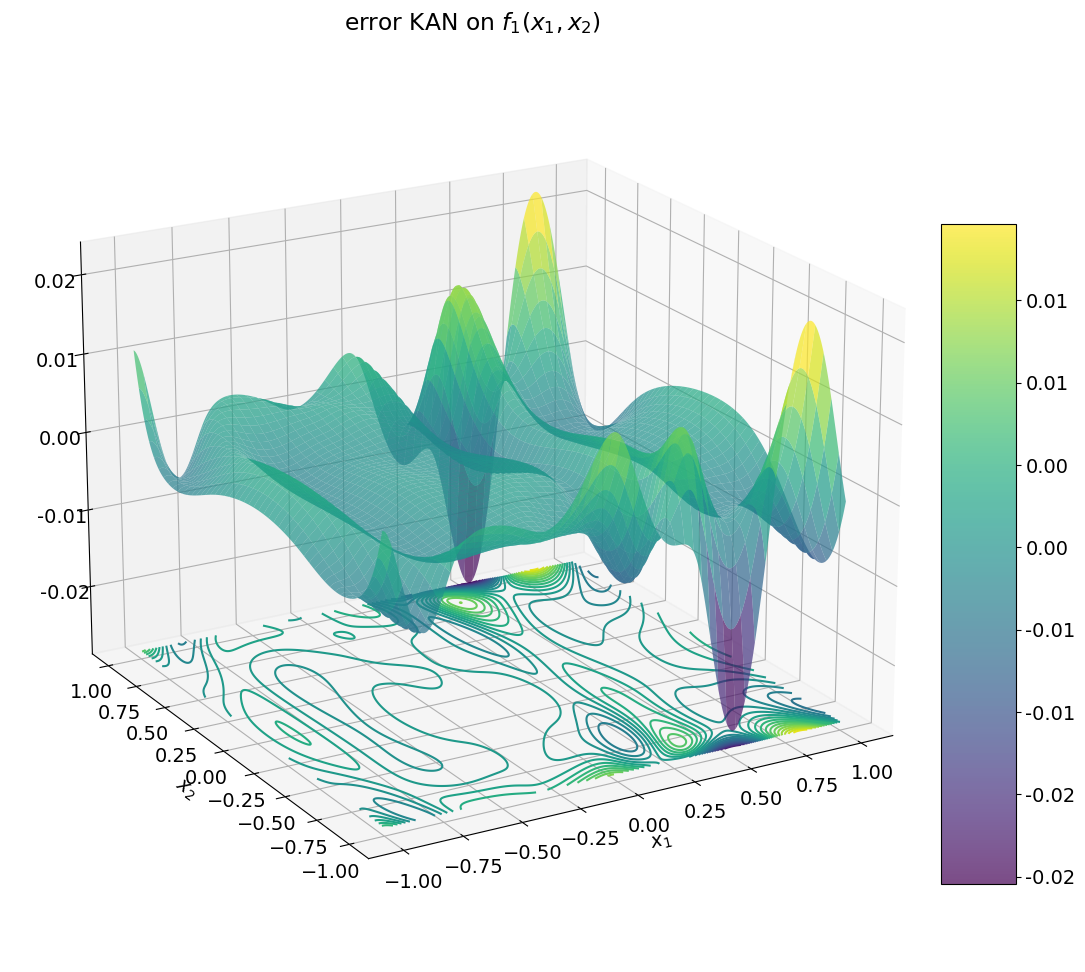

In [6]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


| train_loss: 5.68e-02 | test_loss: 6.95e-02 | reg: 1.65e+01 | : 100%|█| 150/150 [00:55<00:00,  2.72


saving model version 0.1


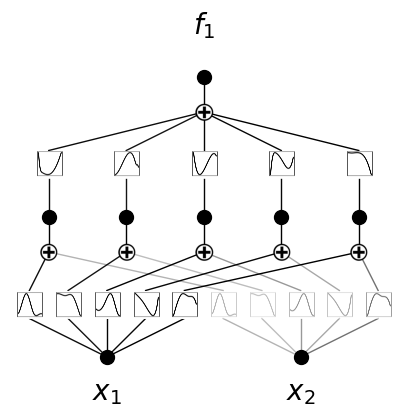

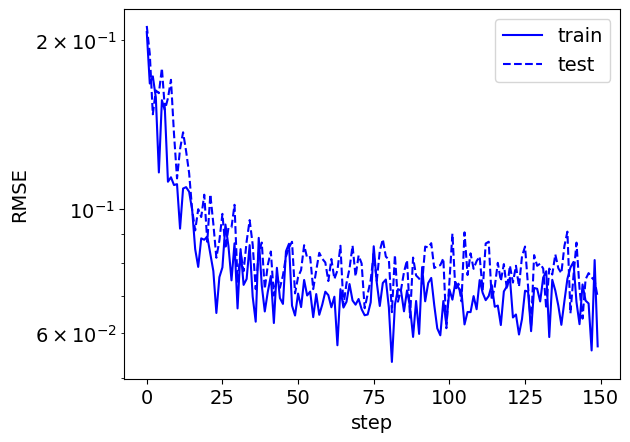

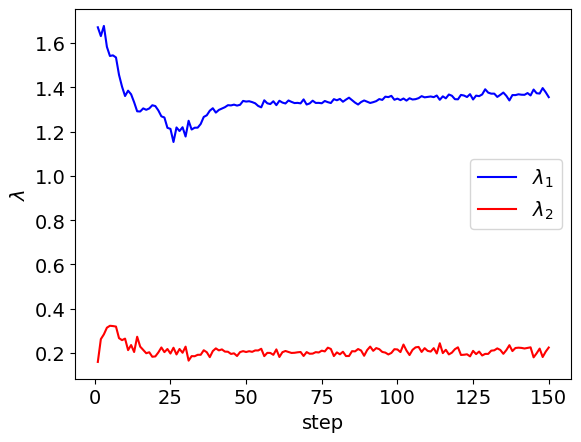

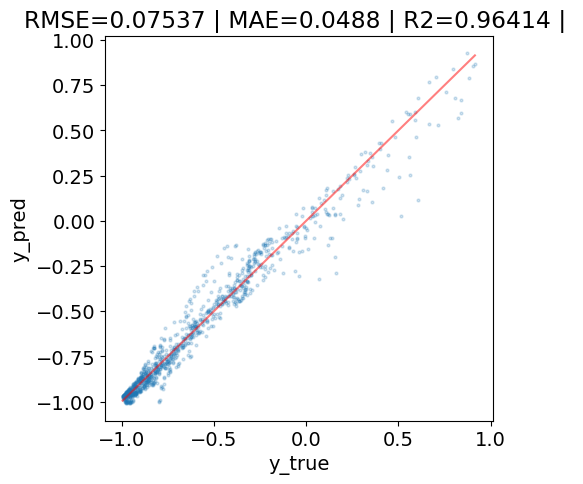

model.act_fun[0].lmd=Parameter containing:
tensor([1.3555, 0.2245], requires_grad=True)


In [7]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$'], out_vars = ['$f_1$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:24, 30.74it/s]                         


module of Input importance:


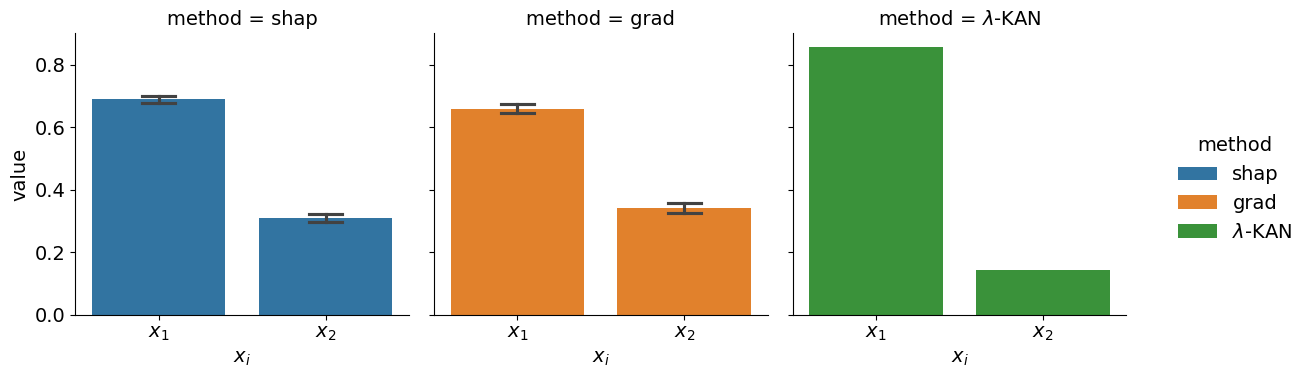

Input importance:


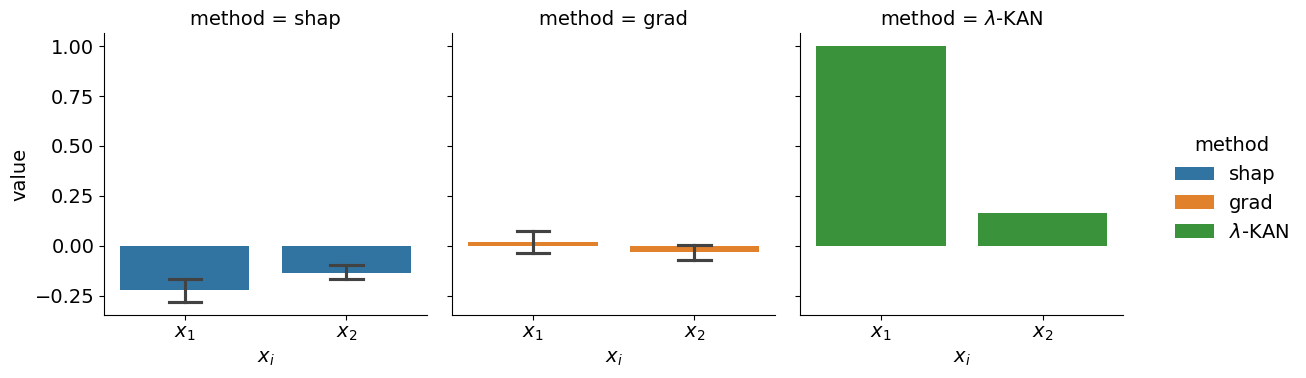

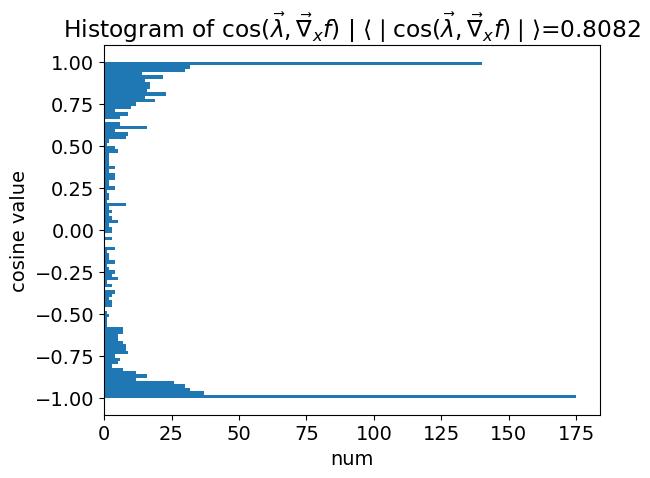

In [8]:
importance_analyse_lmdKAN(model, dataset)

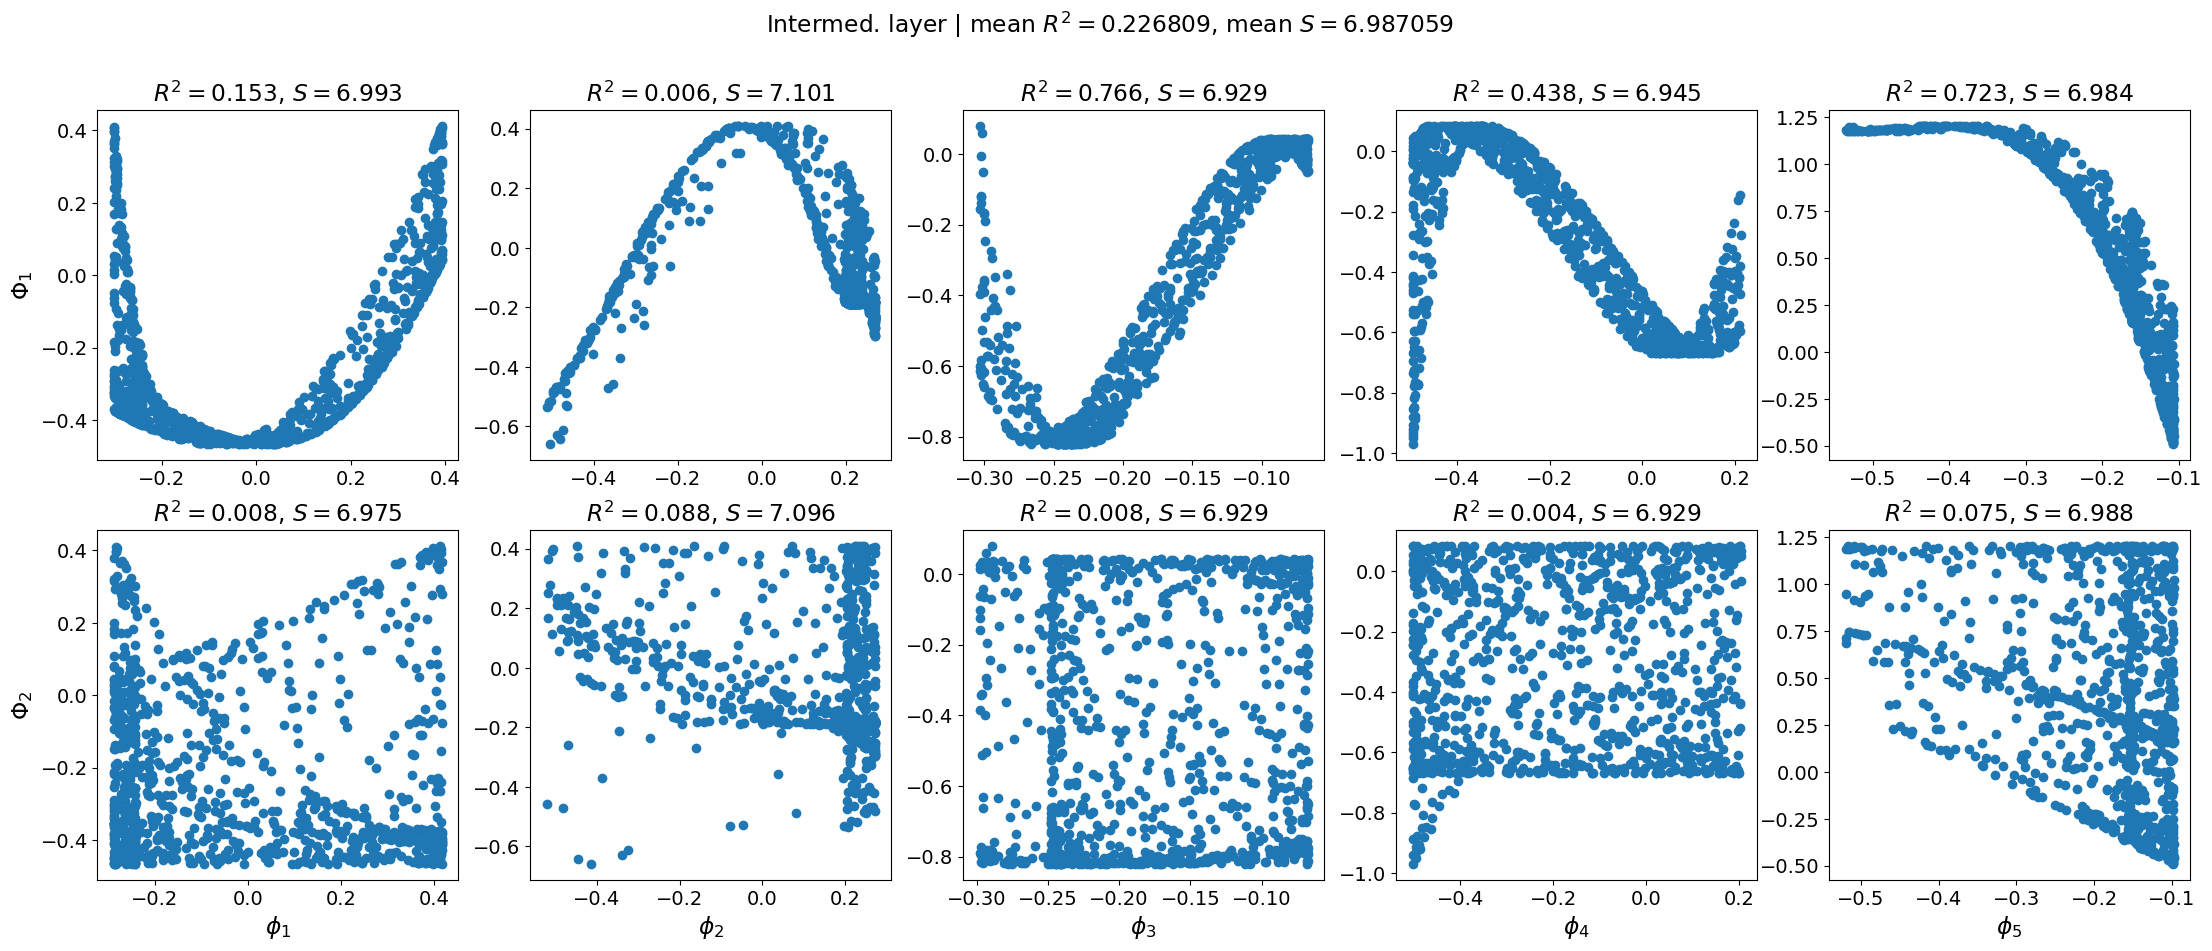

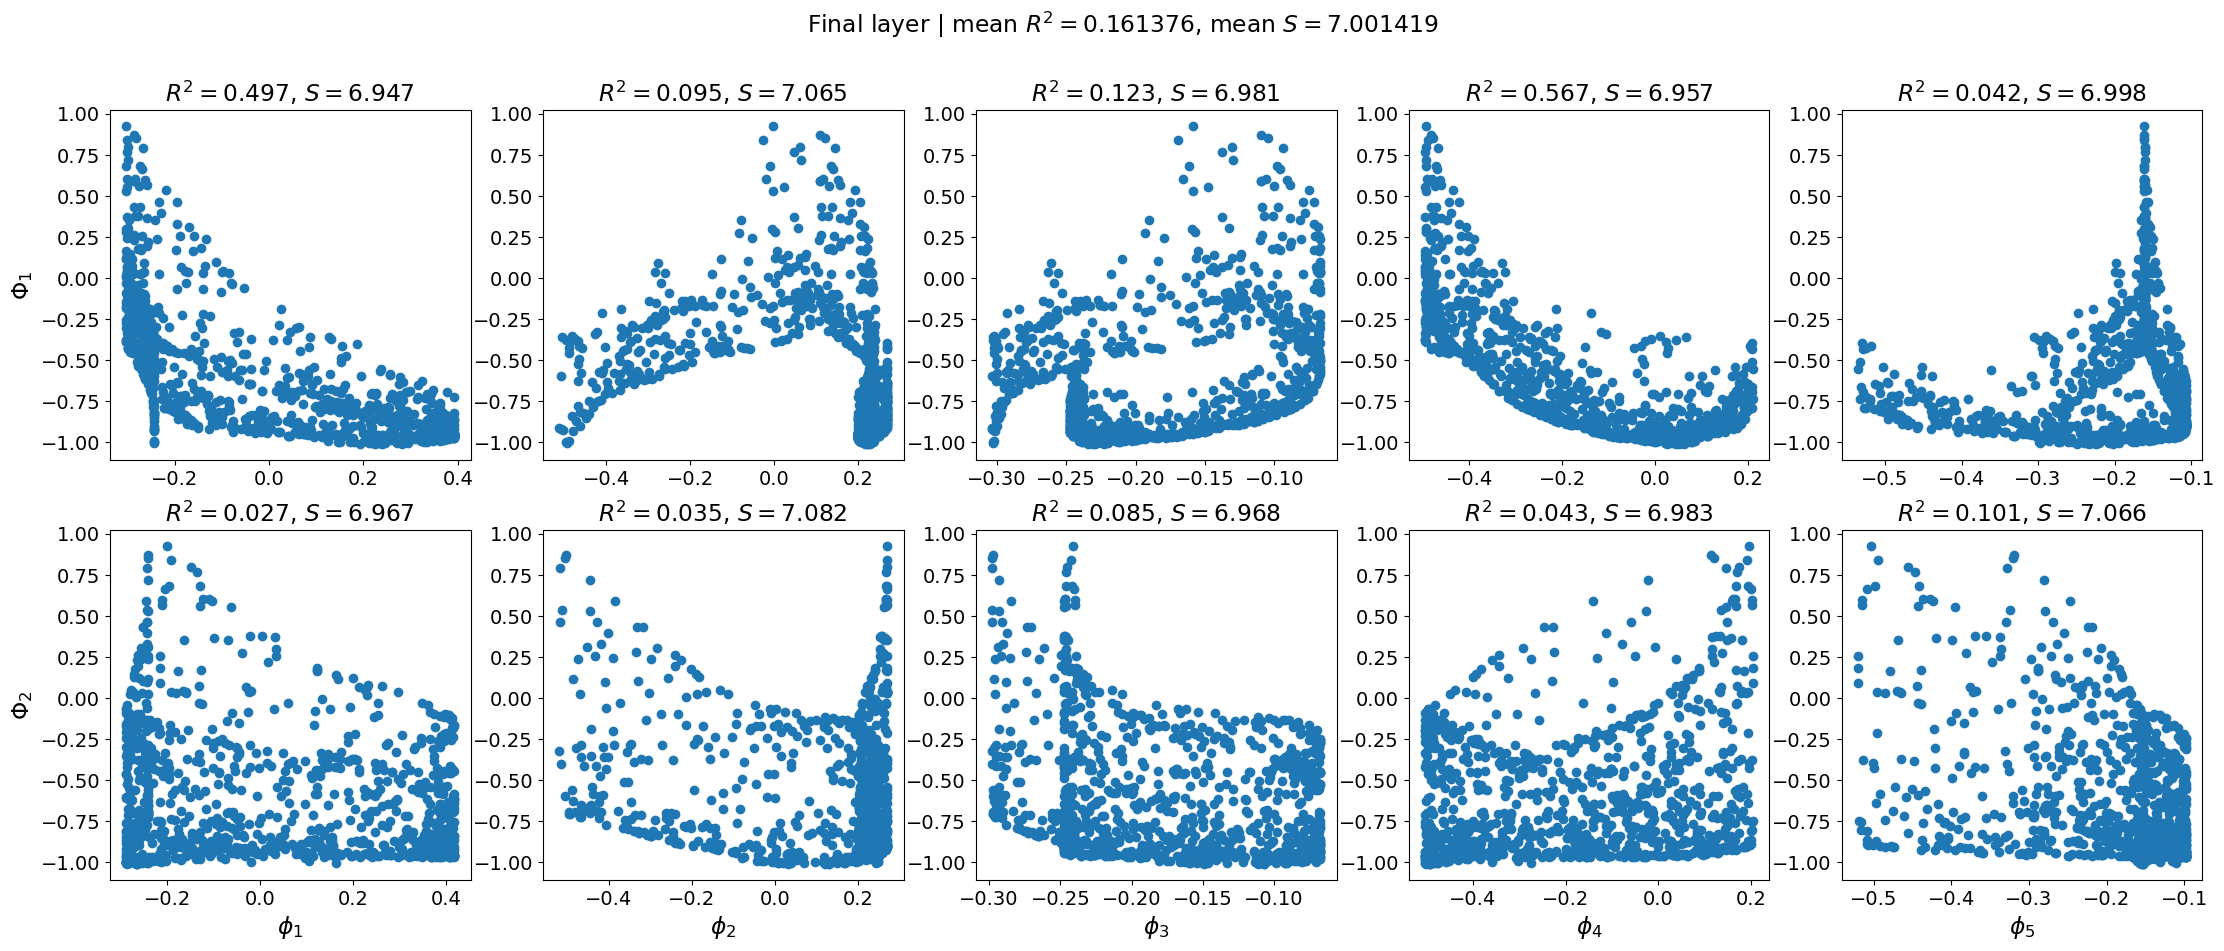

{'mean_r2': 0.1613756265491247, 'mean_matrix_entropy': 7.0014190673828125}

In [9]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

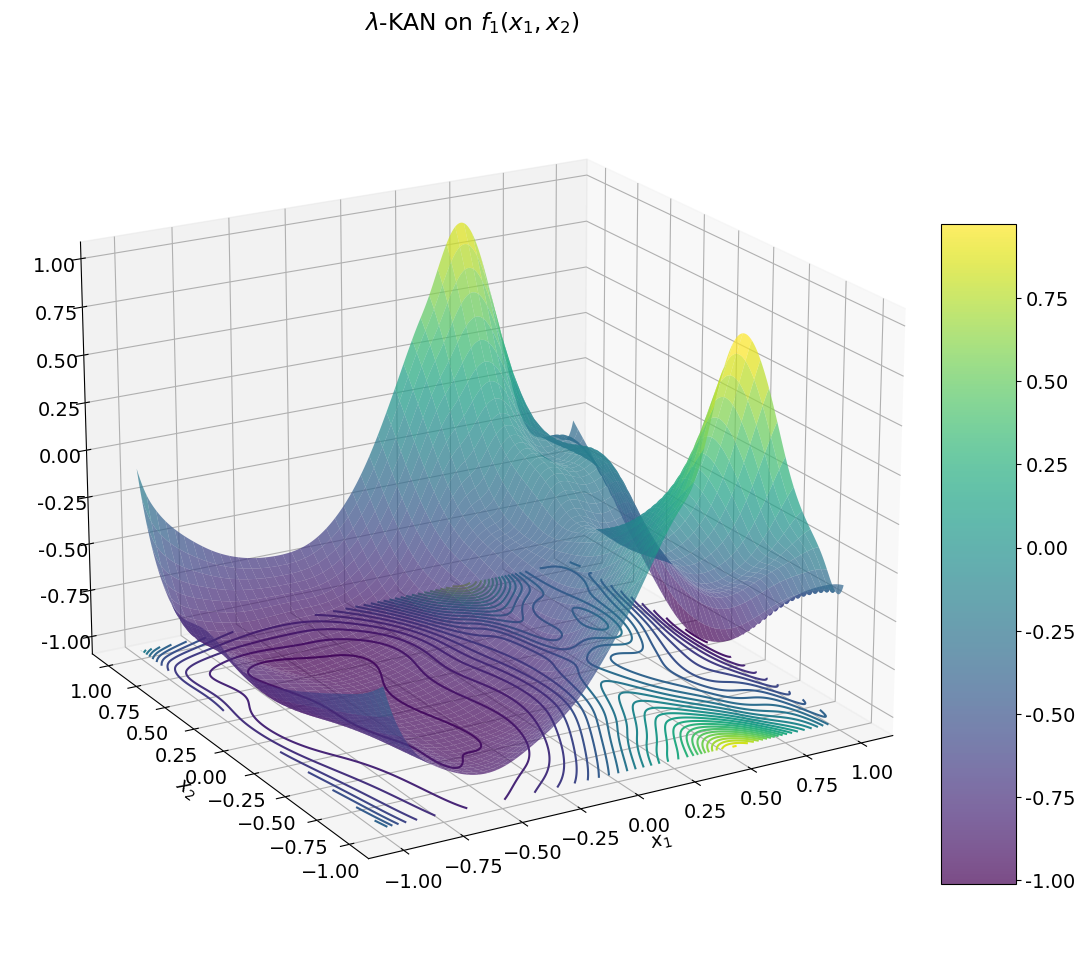

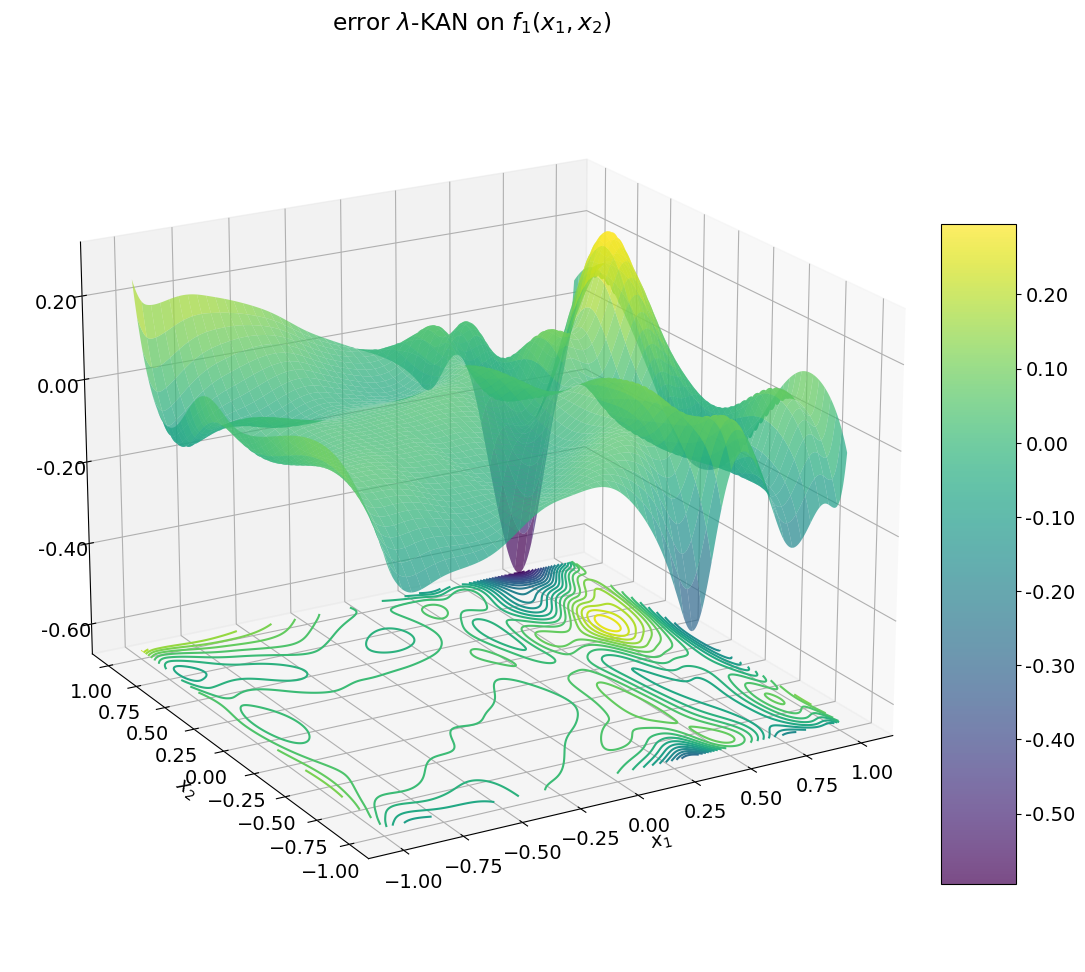

In [10]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
### trainable $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 286


| train_loss: 9.37e-03 | test_loss: 1.05e-02 | reg: 1.36e+01 | : 100%|█| 150/150 [08:32<00:00,  3.42


saving model version 0.1


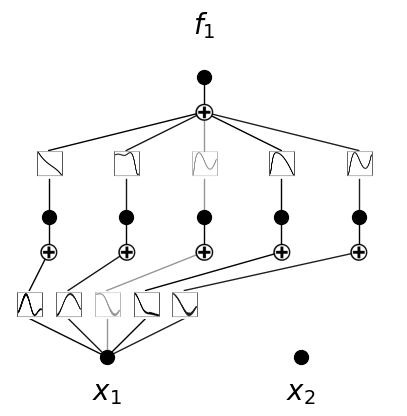

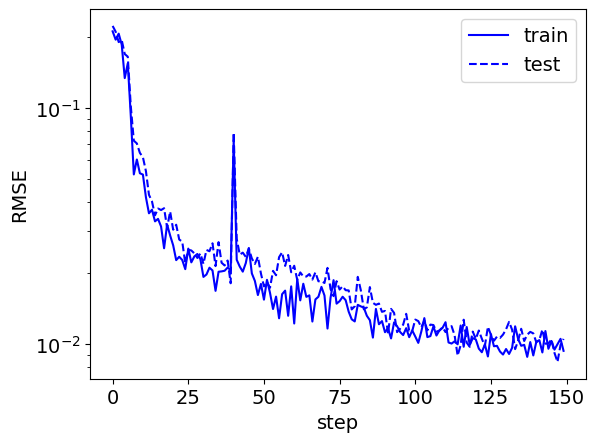

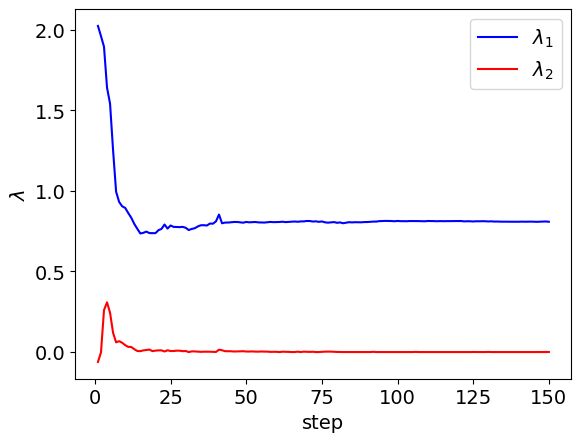

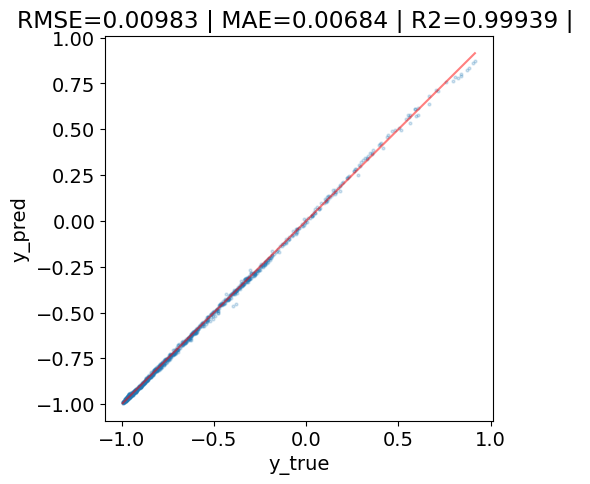

model.act_fun[0].lmd=Parameter containing:
tensor([8.0830e-01, 3.3011e-04], requires_grad=True)


In [11]:
# initialize lmdKAN with G=3
model = tlmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device, tlmd_type='kan', tlmd_width=[3], lmd_init_vector=[1,1], tlmd_alpha=1e-1)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$'], out_vars = ['$f_1$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [01:55,  7.95it/s]                          


module of Input importance:


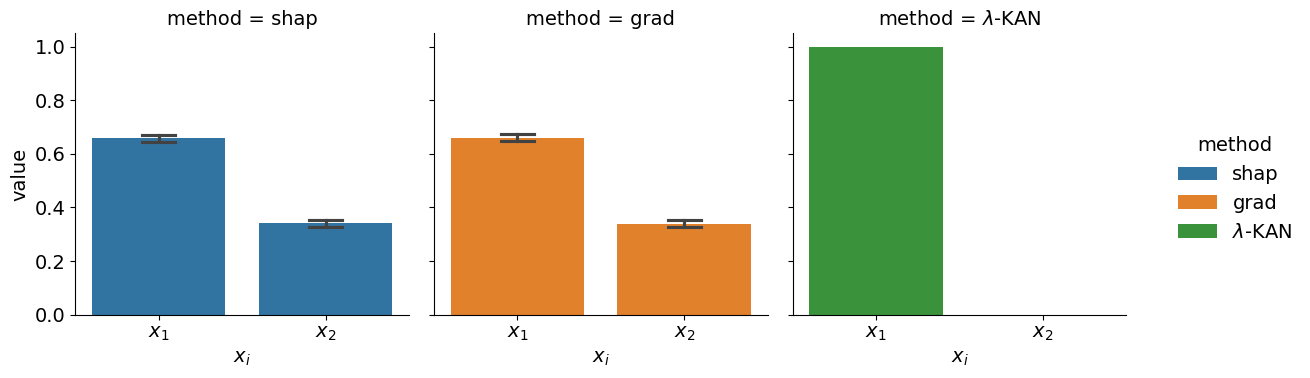

Input importance:


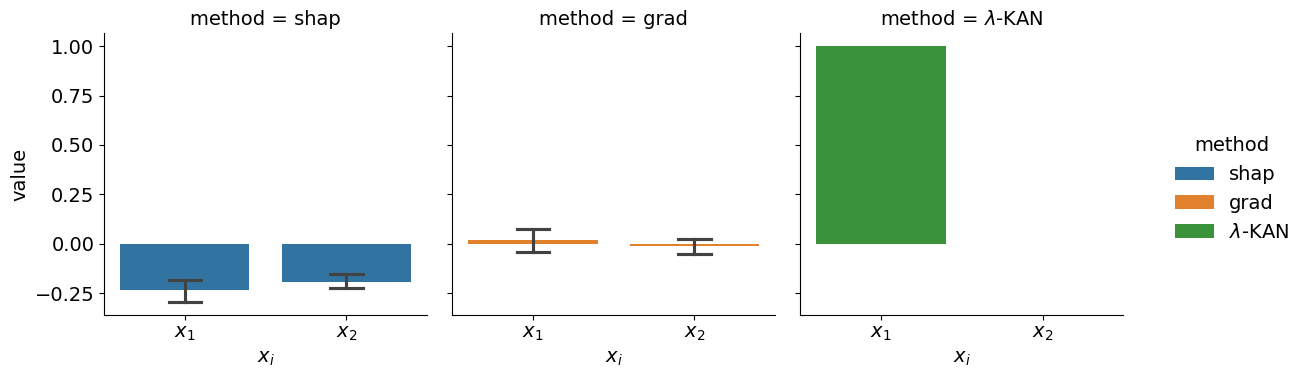

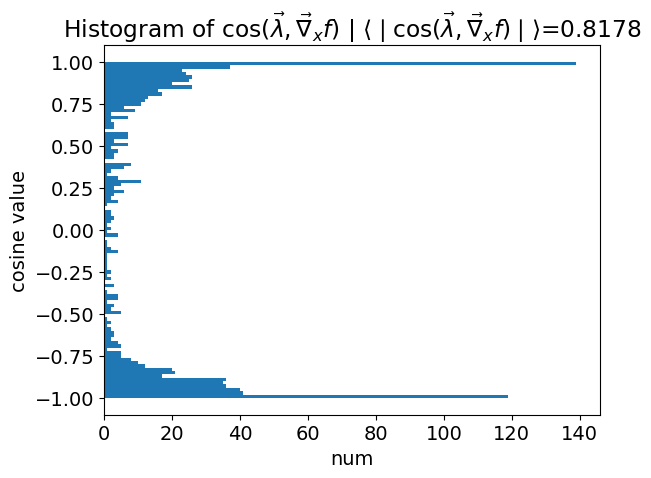

In [12]:
importance_analyse_lmdKAN(model, dataset)

ExactExplainer explainer: 1001it [03:17,  4.57it/s]                          


module of Input importance:


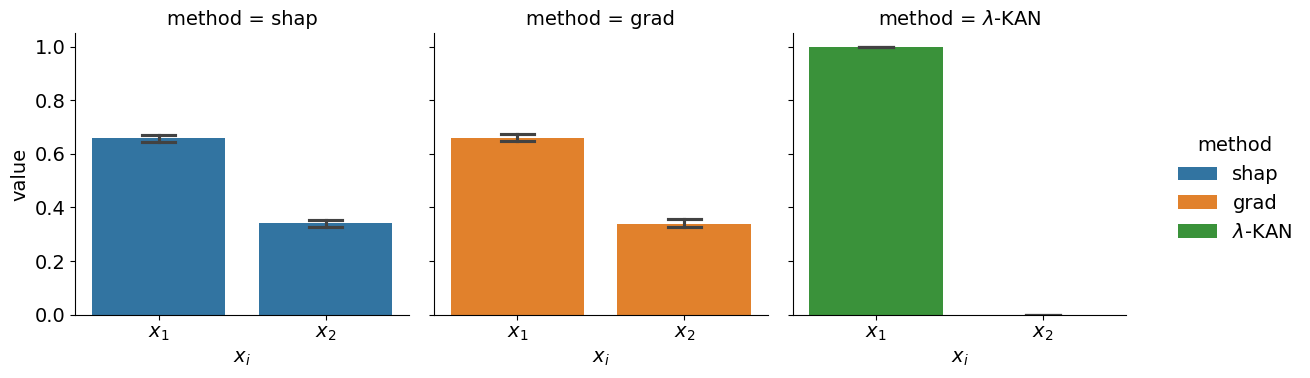

Input importance:


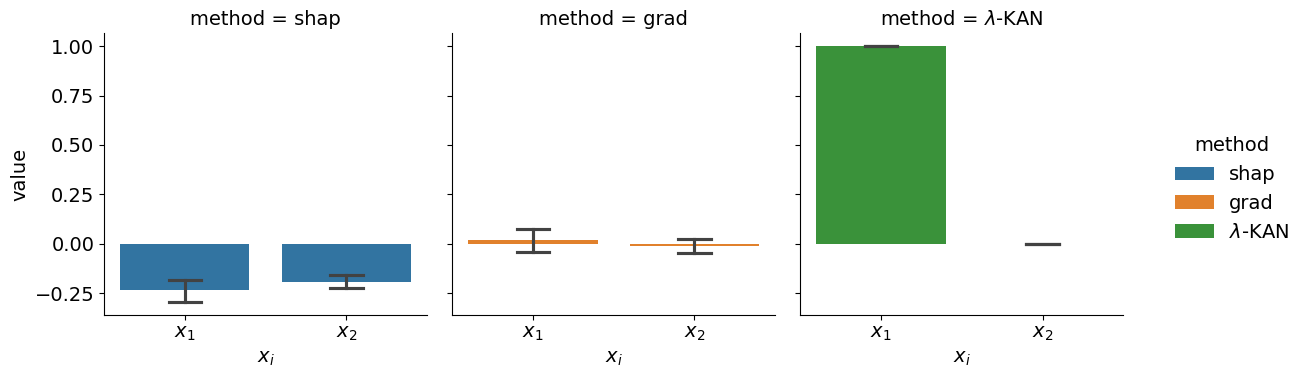

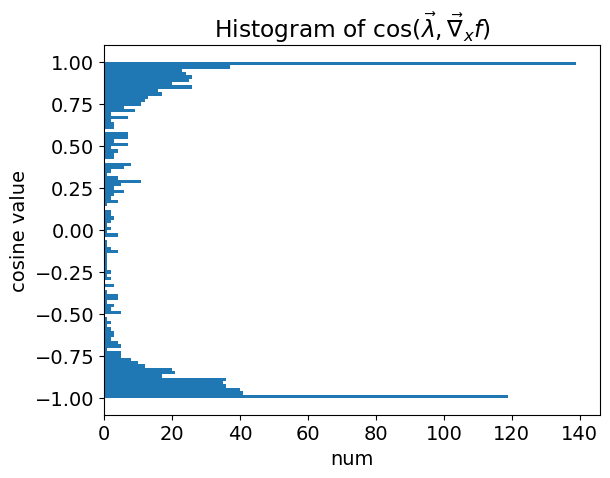

In [13]:
importance_analyse_tlmdKAN(model, dataset)

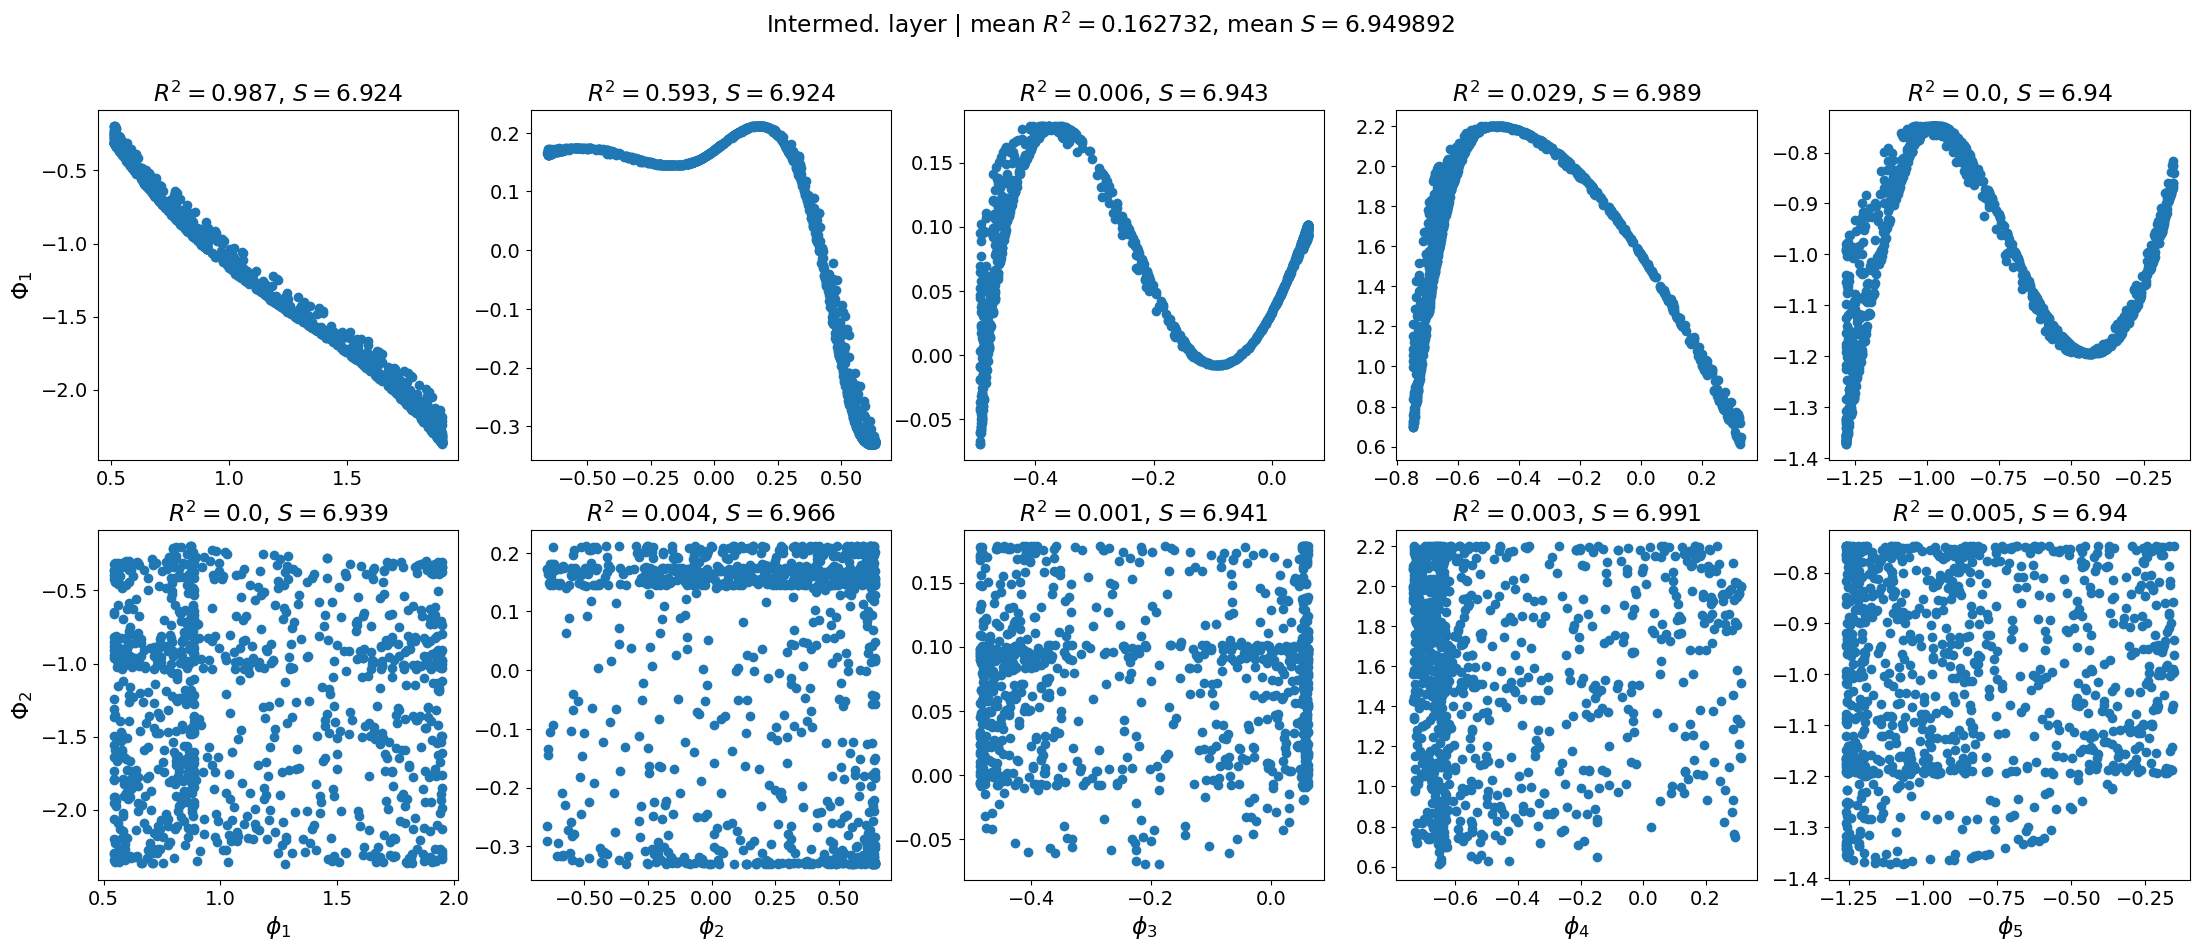

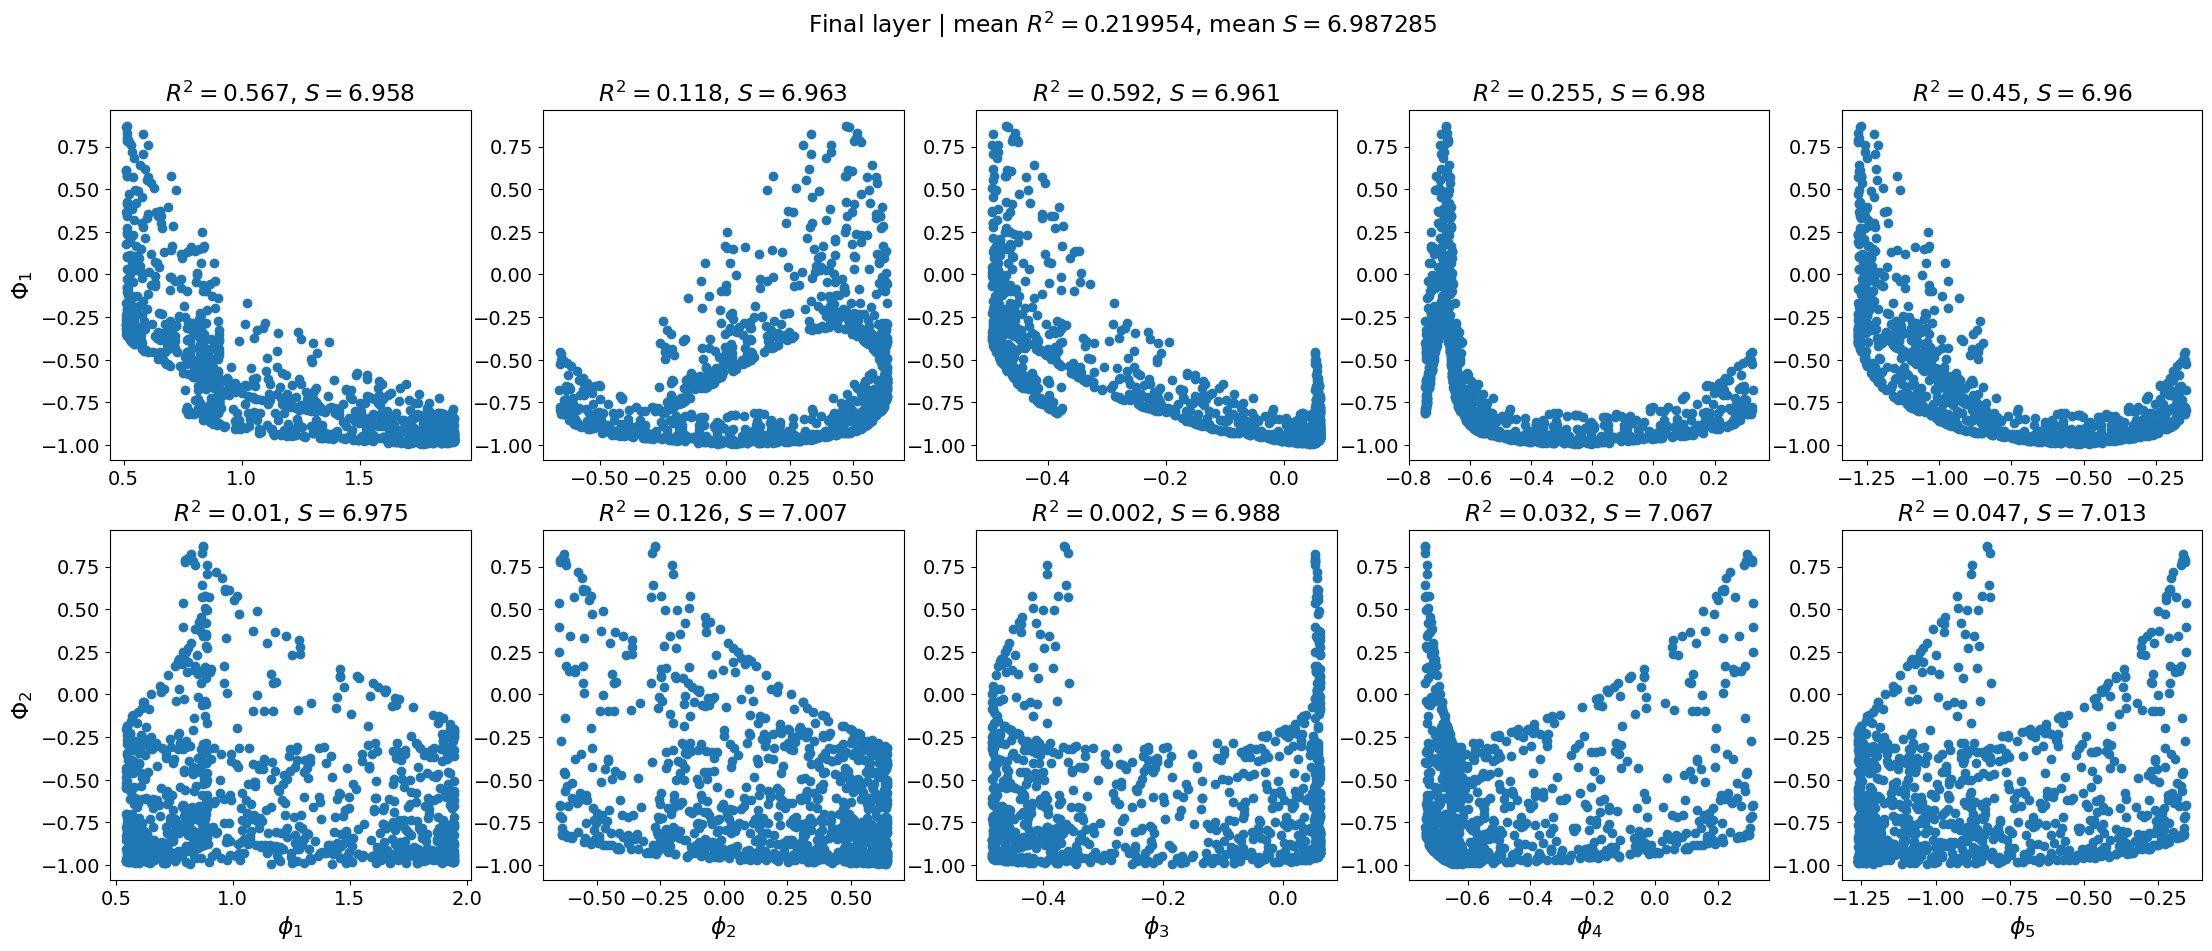

{'mean_r2': 0.21995393210090697, 'mean_matrix_entropy': 6.9872846603393555}

In [14]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

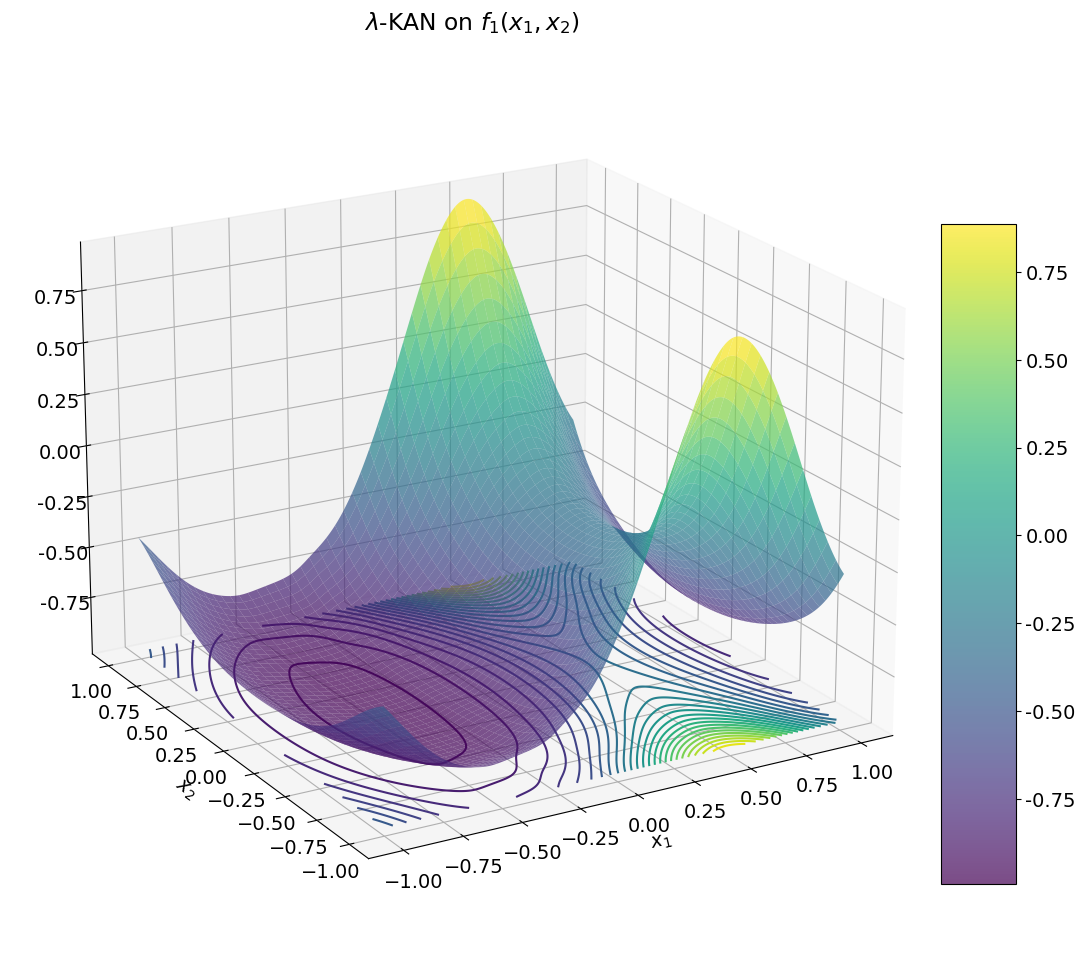

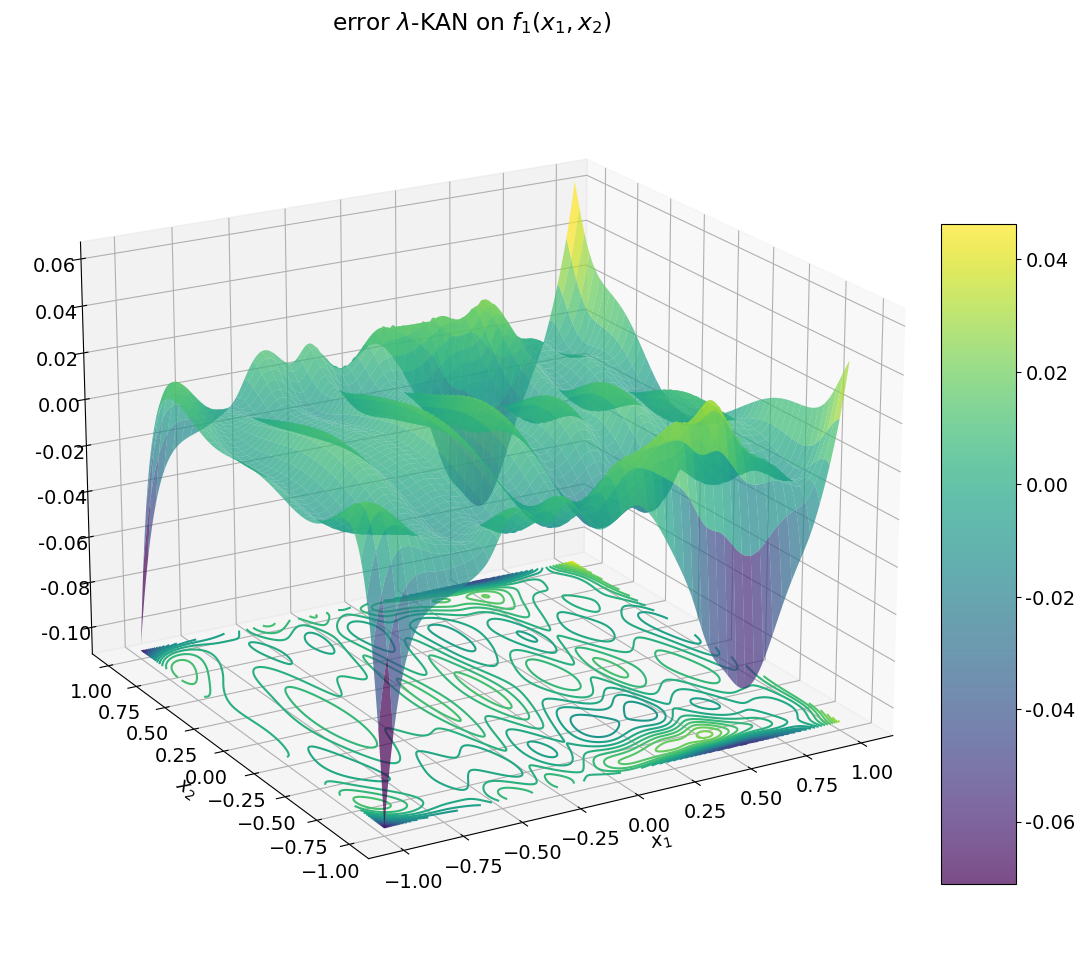

In [15]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

## _Bellow presented code, which was not used in main experiments._

-----
-----
### $\lambda$-KAN on $f_1$ with __R2 regression__ in respect to __Interm. activations__

In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

In [ ]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

In [ ]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$ with __Entropy regression__ in respect to __Interm. activations__

In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

In [ ]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

In [ ]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
-----
### $\lambda$-KAN on $f_1$ with __R2 regression__ in respect to __Final activations__

In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

In [ ]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

In [ ]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$ with __Entropy regression__ in respect to __Final activations__

In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

In [ ]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

In [ ]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')